# How long is long enough ?

In [1]:
using CSV, DataFrames
using Plots
using JuMP, Gurobi

const env = Gurobi.Env()
;

Set parameter Username
Set parameter LicenseID to value 2643818
Academic license - for non-commercial use only - expires 2026-03-28


## Useful functions

In [2]:
function schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C, ρ, η_ch, η_dis, E_init, E_final)

    model = Model(() -> Gurobi.Optimizer(env))

    @variables model begin
            E_min <= e[t in 1:T] <= E_max
            0 <= p_ch[t in 1:T] <= P_ch
            0 <= p_dis[t in 1:T] <= P_dis
            y_ch[t in 1:T], Bin
    end

    @objective(model, Max, sum(C[t] * Δt * (p_dis[t] - p_ch[t]) for t in 1:T))

    @constraints model begin
        StorageBalance[t in 2:T],
            e[t] == ρ * e[t-1] + Δt * (η_ch * p_ch[t] - (1/η_dis) * p_dis[t])
        StorageBalance_init,
            e[1] == ρ * E_init + Δt * (η_ch * p_ch[1] - (1/η_dis) * p_dis[1])
        ChargeLimit[t in 1:T],
            p_ch[t] <= P_ch * y_ch[t]
        DischargeLimit[t in 1:T],
            p_dis[t] <= P_dis * (1 - y_ch[t])
        StorageFinal, 
            e[T] == E_final
    end
    
    set_silent(model)
    optimize!(model)

    profit = []
    e_val = []
    use = []

    if termination_status(model) == MOI.OPTIMAL
        for t in 1:T
            append!(e_val,(JuMP.value.(e[t])))
            profit_t = C[t] * Δt * (JuMP.value.(p_dis[t]) - JuMP.value.(p_ch[t]))
            append!(profit, profit_t)
            append!(use, JuMP.value.(p_dis[t]) + JuMP.value.(p_ch[t]))
        end
    else
        println(termination_status(model))
    end

    return e_val, profit, use
end
;

In [3]:
function min_gap(E_min, E_max, P_ch, P_dis, T, H, C, ρ, η_ch, η_dis, E_init, E_final_up, E_final_low, profit_up, profit_low)

    model = Model(() -> Gurobi.Optimizer(env))
    
    @variables model begin
            E_min <= e_up[t in 1:T] <= E_max
            0 <= p_ch_up[t in 1:T] <= P_ch
            0 <= p_dis_up[t in 1:T] <= P_dis
            E_min <= e_low[t in 1:T] <= E_max
            0 <= p_ch_low[t in 1:T] <= P_ch
            0 <= p_dis_low[t in 1:T] <= P_dis
            0 <= gap
            y_ch_up[t in 1:T], Bin
            y_ch_low[t in 1:T], Bin
        end

    @objective(model, Min, gap)

    @constraints model begin
        StorageBalanceUp[t in 2:T],
            e_up[t] == ρ * e_up[t-1] + Δt * (η_ch * p_ch_up[t] - (1/η_dis) * p_dis_up[t])
        StorageBalanceUp_init,
            e_up[1] == ρ * E_init + Δt * (η_ch * p_ch_up[1] - (1/η_dis) * p_dis_up[1])
        StorageFinalUp,
            e_up[T] == E_final_up
        ProfitUp,
            (profit_up - sum(C[t] * Δt * (p_dis_up[t] - p_ch_up[t]) for t in 1:T)) == 0
        StorageBalanceLow[t in 2:T],
            e_low[t] == ρ * e_low[t-1] + Δt * (η_ch * p_ch_low[t] - (1/η_dis) * p_dis_low[t])
        StorageBalanceLow_init,
            e_low[1] == ρ * E_init + Δt * (η_ch * p_ch_low[1] - (1/η_dis) * p_dis_low[1])
        StorageFinalLow,
            e_low[T] == E_final_low
        ProfitLow,
            (profit_low - sum(C[t] * Δt * (p_dis_low[t] - p_ch_low[t]) for t in 1:T)) == 0
        Gap,
            gap == e_up[H] - e_low[H]
        ChargeLimitUp[t in 1:T],
            p_ch_up[t] <= P_ch * y_ch_up[t]
        DischargeLimitUp[t in 1:T],
            p_dis_up[t] <= P_dis * (1 - y_ch_up[t])
        ChargeLimitLow[t in 1:T],
            p_ch_low[t] <= P_ch * y_ch_low[t]
        DischargeLimitLow[t in 1:T],
            p_dis_low[t] <= P_dis * (1 - y_ch_low[t])
        end
    
    set_silent(model)
    optimize!(model)

    e_up_val=[E_init]
    e_low_val=[E_init]
    gap_val = 1000
    profit_up_val = []
    profit_low_val = []
    use_up = []

    if termination_status(model) == MOI.OPTIMAL
        for t in 1:T
            append!(e_up_val,JuMP.value.(e_up[t]))
            append!(e_low_val,JuMP.value.(e_low[t]))
            append!(profit_up_val, C[t] * Δt * (JuMP.value.(p_dis_up[t]) - JuMP.value.(p_ch_up[t])))
            append!(profit_low_val, C[t] * Δt * (JuMP.value.(p_dis_low[t]) - JuMP.value.(p_ch_low[t])))
            append!(use_up, JuMP.value.(p_dis_up[t]) + JuMP.value.(p_ch_up[t]))
        end
        gap_val = JuMP.value(gap)
    else
        println(termination_status(model))
    end

    return gap_val , e_up_val, e_low_val, profit_up_val, profit_low_val, use_up
end
;

In [4]:
function min_fcst_hor(t, H, T_min, T_max, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_half)

    T = min(T_min, T_max)
    gap = 1000
    e_val = []
    profit = []
    use = []

    while gap > 0 && T <= T_max
        # Calculate max reachable level and min reachable level
        E_final_up = min(E_max, E_init * ρ^T + Δt * η_ch * P_ch * sum(ρ^(i-1) for i in 1:T))
        E_final_low = max(E_min, E_init * ρ^T - Δt *(1/η_dis) * P_dis * sum(ρ^(i-1) for i in 1:T))

        # Solve for those
        e_val_up, profit_up, use_up = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_final_up)
        e_val_low, profit_low, use_low = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_final_low)

        if e_val_up[H] == e_val_low[H]
            gap = 0
        else
            # Check for solution multiplicity
            gap, e_val_up_gap, e_val_low_gap, profit_up_gap, profit_low_gap, use_up = min_gap(E_min, E_max, P_ch, P_dis, T, H, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_final_up, E_final_low, sum(profit_up), sum(profit_low))
            if gap==0 && ((sum(profit_up_gap)-sum(profit_up))*10e18 != 0 || (sum(profit_low_gap)-sum(profit_low))*10e18 != 0)
                gap = e_val_up[H] - e_val_low[H]
            end
        end

        e_val = e_val_low[1:H]
        profit = profit_low[1:H]
        use = use_low[1:H]

        T+=1
    end

    T-=1

    if T == T_max
        e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_half)
        println("T_max reached for t=",t,", with a gap=",gap)
    end


    return T, e_val, profit[1:H], use[1:H]
end
;

In [5]:
function subopt_UB(t, H, T_min, T_max, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_init_all, E_half, C_min, C_max)

    T = min(T_min, T_max)
    gap = 1000
    gap_vec = []
    subopt_bound_vec =[]

    while gap > 0 && T <= T_max
        # Calculate max reachable level and min reachable level
        E_final_up = min(E_max, E_init * ρ^T + Δt * η_ch * P_ch * sum(ρ^(i-1) for i in 1:T))
        E_final_low = max(E_min, E_init * ρ^T - Δt *(1/η_dis) * P_dis * sum(ρ^(i-1) for i in 1:T))

        # Solve for those
        e_val_up, profit_up, use_up = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_final_up)
        e_val_low, profit_low, use_low = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_final_low)

        if e_val_up[H] == e_val_low[H]
            gap = 0
        else
            gap, e_val_up_gap, e_val_low_gap, profit_up_gap, profit_low_gap, use_up = min_gap(E_min, E_max, P_ch, P_dis, T, H, C[t:T+t-1], ρ, η_ch, η_dis, E_init, E_final_up, E_final_low, sum(profit_up), sum(profit_low))
            if gap==0 && ((sum(profit_up_gap)-sum(profit_up))*10e18 != 0 || (sum(profit_low_gap)-sum(profit_low))*10e18 != 0)
                e_val_up = e_val_up_gap
                e_val_low = e_val_low_gap
                gap = e_val_up[H]-e_val_low[H]
            end
        end

        append!(gap_vec,gap)

        e_end, profit = schedule_bin_bounds(E_min, E_max, P_ch, P_dis, H, C[t:H+t-1], ρ, η_ch, η_dis, E_init, e_val_low[H], e_val_up[H])
        subopt_bound = max(-C_min * (1/η_ch) * (e_end-e_val_low[H]), C_max * η_dis * (e_val_up[H]-e_end))
        append!(subopt_bound_vec, subopt_bound)

        T+=1
    end

    T-=1

    if T == T_max
        println("T_max too low")
    end

    return gap_vec, subopt_bound_vec
end
;

In [6]:
function schedule_bin_bounds(E_min, E_max, P_ch, P_dis, T, C, ρ, η_ch, η_dis, E_init, E_final_min, E_final_max)

    model = Model(() -> Gurobi.Optimizer(env))

    @variables model begin
            E_min <= e[t in 1:T] <= E_max
            0 <= p_ch[t in 1:T] <= P_ch
            0 <= p_dis[t in 1:T] <= P_dis
            y_ch[t in 1:T], Bin
    end


    @objective(model, Max, sum(C[t] * Δt * (p_dis[t] - p_ch[t]) for t in 1:T))

    @constraints model begin
        StorageBalance[t in 2:T],
            e[t] == ρ * e[t-1] + Δt * (η_ch * p_ch[t] - (1/η_dis) * p_dis[t])
        StorageBalance_init,
            e[1] == ρ * E_init + Δt * (η_ch * p_ch[1] - (1/η_dis) * p_dis[1])
        ChargeLimit[t in 1:T],
            p_ch[t] <= P_ch * y_ch[t]
        DischargeLimit[t in 1:T],
            p_dis[t] <= P_dis * (1 - y_ch[t])
        StorageFinal, 
            E_final_min <= e[T] <= E_final_max
    end
    
    set_silent(model)
    optimize!(model)

    return JuMP.value.(e[T]), objective_value(model)
end
;

## Non existence

In [7]:
# Price data
C = (0.001).*[55, 45, 54, 45, 54, 45, 54, 45, 54, 45, 54, 45, 54, 45]

# Storage data
P_ch = 11.0 # Max charge (kW)
P_dis = 10.0 # Max discharge (kW)
η_ch = 0.9 # Charging efficiency
η_dis = 0.9 # Discharging efficiency
E_min = 0.0 # Min capacity (kWh)
E_max = 10.0 # Max capacity (kWh)
E_half = E_max / 2
E_init = E_half # Initial state of energy (kWh)
ρ = 1.0 # Proportion of stored energy that is still available in the next period (i.e. does not leak)

# Time
H = 1  # Decision horizon (hours)
Δt = 1 # Duration of each time interval (hours)
T_tot = 10
T_max = T_tot # Maximum planning horizon (hours)
T_plt_fcst = T_tot

theme(:dao)
;

In [8]:
e_min = [E_init]
e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T_tot , C[1:T_tot], ρ, η_ch, η_dis, E_init, E_min)
append!(e_min, e_val[1:T_tot])
e_max = [E_init]
e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T_tot , C[1:T_tot], ρ, η_ch, η_dis, E_init, E_max)
append!(e_max, e_val[1:T_tot])
;

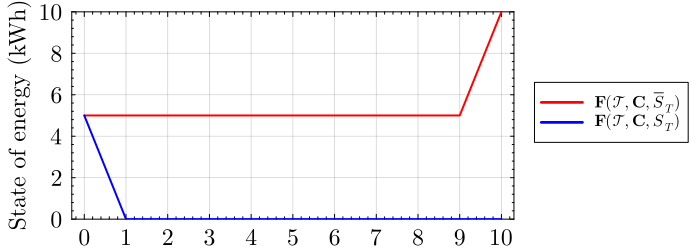

In [9]:
# Plot soe
using LaTeXStrings
plt_soe = plot(legend=:outerright, legendfontsize=11, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, ylims=[E_min,E_max], xticks=0:1*H:T_tot, size=(700,250), ylabel="State of energy (kWh)", bottom_margin=2Plots.mm, left_margin=5Plots.mm) # , title="State of energy"
plot!(plt_soe, [0:T_tot], e_max[1:T_tot+1], linewidth=2, color=:red, label=L" $\textbf{F}(\mathcal{T}, \textbf{C}, \overline{S}_T)$")
plot!(plt_soe, [0:T_tot], e_min[1:T_tot+1], linewidth=2, color=:blue, label=L" $\textbf{F}(\mathcal{T}, \textbf{C}, {S}_T)$")

In [10]:
savefig(plt_soe,"soe_ex.pdf");

## Prices

In [11]:
# Import data
year = "2024"
file_name = string("Day-ahead Prices_", year, ".csv")
C_df = CSV.read(file_name, DataFrame)
C = 0.001*(C_df.Price)

# Time
H = 24  # Decision horizon (hours)
Δt = 1 # Duration of each time interval (hours)
T_tot = 24 * 30 * 3
T_max = T_tot # Maximum planning horizon (hours)
T_plt_fcst = min(T_tot, 1944)

theme(:dao)
;

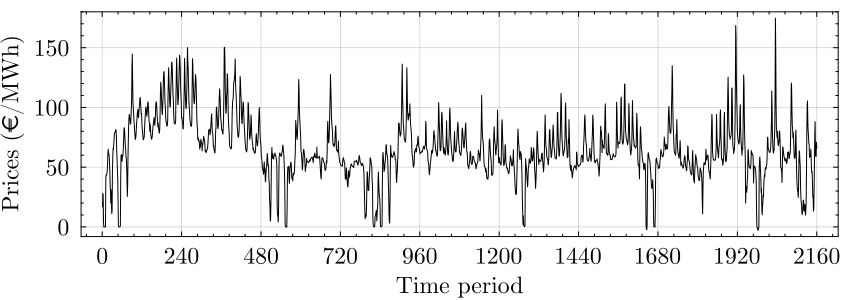

In [12]:
# Plot prices
plt_prices = plot(tickfontsize=15, minorgrid=false, gridalpha=0.1, guidefontsize=15, titlefontsize=15, legend=false, xticks=0:10*H:T_tot, size=(850,300), ylabel="Prices (€/MWh)", xlabel="Time period", left_margin=4Plots.mm, bottom_margin=7Plots.mm) #, title="Prices"
plot!(plt_prices, [1:T_tot], (1000).*C[1:T_tot], linewidth=1, color=:black)

In [13]:
savefig(plt_prices,"prices.pdf");

## Fast storage

In [14]:
# Storage data
P_ch = 1.0 # Max charge (kW)
P_dis = 1.0 # Max discharge (kW)
η_ch = 0.9 # Charging efficiency
η_dis = 0.9 # Discharging efficiency
E_min = 0.0 # Min capacity (kWh)
E_max = 10.0 # Max capacity (kWh)
E_half = E_max / 2
E_init_all = E_half # Initial state of energy (kWh)
ρ = 1.0 # Proportion of stored energy that is still available in the next period (i.e. does not leak)

color_fast="#a6cee3"
;

### Fixed final level

In [15]:
E_init = E_init_all
e_fix = [E_init]
profit_fix =[0.0]
use_fix =[0.0]
t = 1

while t <= T_tot
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, H , C[t:t+H-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_fix, e_val[1:H])
    append!(profit_fix, profit[1:H])
    append!(use_fix, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_fix), digits=3))
println("Total storage use: ",round(sum(use_fix), digits=3))

Total profit: 12.319
Total storage use: 1061.464


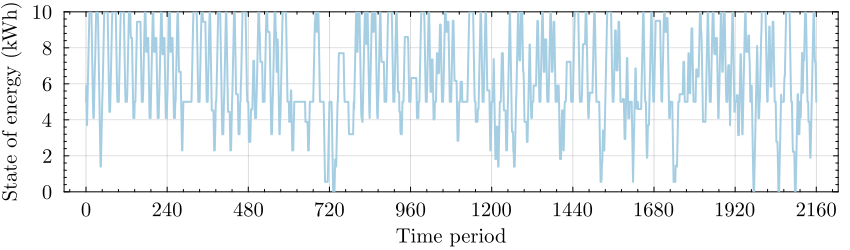

In [16]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_fix[1:T_tot+1], linewidth=2, color=color_fast)

In [17]:
savefig(plt_soe,"soe_fast_fix.pdf");

### Rolling horizon 2 days

In [18]:
e_RH2 = [E_init_all]
profit_RH2 =[0.0]
use_RH2 =[0.0]
t = 1
T_RH = 48
E_init = E_init_all

while t <= T_tot
    T = min(T_RH, T_tot-t+1)
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T , C[t:t+T-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH2, e_val[1:H])
    append!(profit_RH2, profit[1:H])
    append!(use_RH2, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH2), digits=3))
println("Total storage use: ",round(sum(use_RH2), digits=3))

Total profit: 14.733
Total storage use: 1041.197


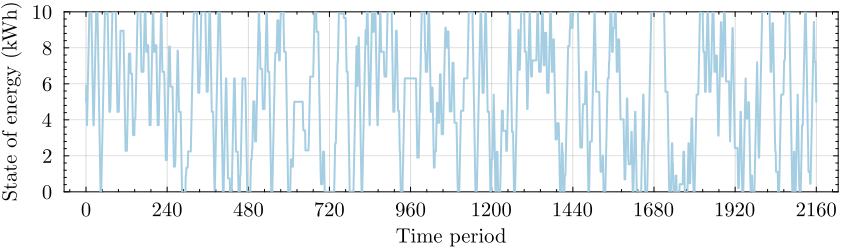

In [19]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH2[1:T_tot+1], linewidth=2, color=color_fast)

In [20]:
savefig(plt_soe,"soe_fast_RH.pdf");

### Minimum forecast horizon

In [21]:
# Min forecast horizon and solving

E_init = E_init_all
e_RH_min = [E_init]
profit_RH_min =[0.0]
use_RH_min =[0.0]
t = 1
T_min_fcst = []
T_LB_1 = []
T_LB_2 = []
T_LB_3 = []
T_LB = []

while t <= T_tot
    println("t=",t)

    # Lower bound on forecast horizon
    expr = 10
    expr_1 = 10
    expr_2 = 10
    expr_3 = 10
    T_min_1 = H+1
    while expr_1 > 0
        expr_1 = E_max - E_min - sum(ρ^i for i=0:T_min_1-H-1) * Δt * (η_ch * P_ch + (1/η_dis) * P_dis)
        T_min_1 += 1
    end
    append!(T_LB_1,(T_min_1-1).*(ones(H)))
    T_min_2 = H+1
    while expr_2 > 0
        expr_2 = ρ^T_min_2 * E_init - E_min + sum(ρ^i for i=T_min_2-H:T_min_2-1) * Δt * (η_ch * P_ch) - sum(ρ^i for i=0:T_min_2-H-1) * Δt * ((1/η_dis) * P_dis)
        T_min_2 += 1
    end
    append!(T_LB_2,(T_min_2-1).*(ones(H)))
    T_min_3 = H+1
    while expr_3 > 0
        expr_3 = E_max - ρ^T_min_3 * E_init - sum(ρ^i for i=0:T_min_3-H-1) * Δt * (η_ch * P_ch) + sum(ρ^i for i=T_min_3-H:T_min_3-1) * Δt * ((1/η_dis) * P_dis)
        T_min_3 += 1
    end
    append!(T_LB_3,(T_min_3-1).*(ones(H)))
    T_min = (min(T_min_1,T_min_2,T_min_3)-1)
    append!(T_LB,T_min.*(ones(H)))
    println("T_min = ", T_min)
    if T_min > T_max 
        println("The maximum planning horizon is too short")
    end

    # Min forecast horizon
    T_max_end = min(T_max, T_tot-t+1)
    T_fcst, e_val, profit, use = min_fcst_hor(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH_min, e_val[1:H])
    append!(profit_RH_min, profit[1:H])
    append!(use_RH_min, use[1:H])
    append!(T_min_fcst, T_fcst.*(ones(H)))
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH_min), digits=3))
println("Total storage use: ",round(sum(use_RH_min), digits=3))

t=1
T_min = 29
t=25
T_min = 29
t=49
T_min = 29
t=73
T_min = 29
t=97
T_min = 29
t=121
T_min = 29
t=145
T_min = 29
t=169
T_min = 29
t=193
T_min = 29
t=217
T_min = 29
t=241
T_min = 29
t=265
T_min = 29
t=289
T_min = 29
t=313
T_min = 29
t=337
T_min = 29
t=361
T_min = 29
t=385
T_min = 29
t=409
T_min = 29
t=433
T_min = 29
t=457
T_min = 29
t=481
T_min = 29
t=505
T_min = 29
t=529
T_min = 29
t=553
T_min = 29
t=577
T_min = 29
t=601
T_min = 29
t=625
T_min = 29
t=649
T_min = 29
t=673
T_min = 29
t=697
T_min = 29
t=721
T_min = 29
t=745
T_min = 29
t=769
T_min = 29
t=793
T_min = 29
t=817
T_min = 29
t=841
T_min = 29
t=865
T_min = 29
t=889
T_min = 29
t=913
T_min = 29
t=937
T_min = 29
t=961
T_min = 29
t=985
T_min = 29
t=1009
T_min = 29
t=1033
T_min = 29
t=1057
T_min = 29
t=1081
T_min = 29
t=1105
T_min = 29
t=1129
T_min = 29
t=1153
T_min = 29
t=1177
T_min = 29
t=1201
T_min = 29
t=1225
T_min = 29
t=1249
T_min = 29
t=1273
T_min = 29
t=1297
T_min = 29
t=1321
T_min = 29
t=1345
T_min = 29
t=1369
T_min = 29
t=13

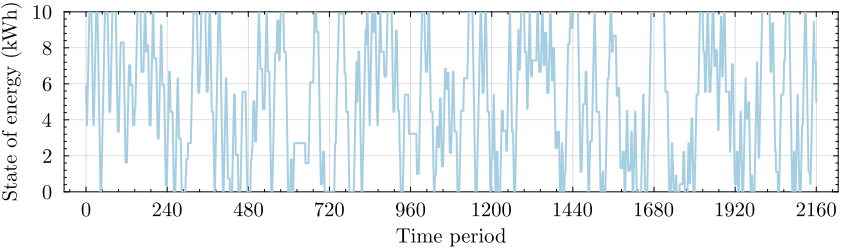

In [22]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH_min[1:T_tot+1], linewidth=2, color=color_fast)

In [23]:
savefig(plt_soe,"soe_fast_fcst.pdf");

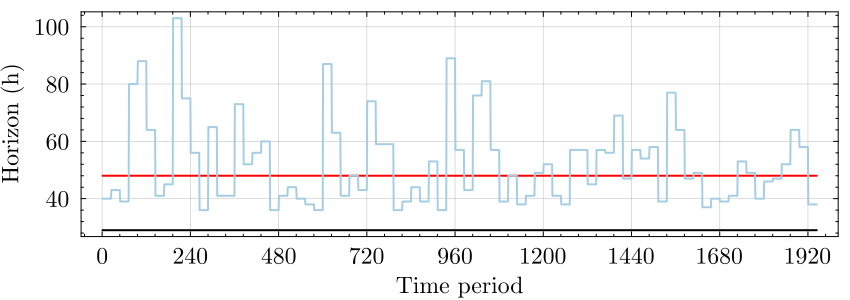

In [24]:
# Plot min horizon
plt_fcst = plot(legend=false, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, xticks=0:10*H:T_tot, size=(850,300), ylabel="Horizon (h)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_fcst, [1:T_plt_fcst], (T_RH).*ones(T_plt_fcst), linewidth=2, color=:red)
plot!(plt_fcst, [1:T_plt_fcst], T_LB[1:T_plt_fcst], linewidth=2, color=:black)
plot!(plt_fcst, [1:T_plt_fcst], T_min_fcst[1:T_plt_fcst], linewidth=2, color=color_fast)

In [25]:
T_min_fcst_1 = T_min_fcst[1:T_plt_fcst];

In [26]:
savefig(plt_fcst,"min_fcst_fast.pdf");

## Fast storage + low eff

In [27]:
# Storage data
P_ch = 1.5 # Max charge (kW)
P_dis = 0.7 # Max discharge (kW)
η_ch = 0.6 # Charging efficiency
η_dis = 0.6 # Discharging efficiency
E_min = 0.0 # Min capacity (kWh)
E_max = 10.0 # Max capacity (kWh)
E_half = E_max / 2
E_init_all = E_half # Initial state of energy (kWh)
ρ = 1.0 # Proportion of stored energy that is still available in the next period (i.e. does not leak)

color_eff="#1f78b4"
;

### Fixed final level

In [28]:
E_init = E_init_all
e_fix = [E_init]
profit_fix =[0.0]
use_fix =[0.0]
t = 1

while t <= T_tot
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, H , C[t:t+H-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_fix, e_val[1:H])
    append!(profit_fix, profit[1:H])
    append!(use_fix, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_fix), digits=3))
println("Total storage use: ",round(sum(use_fix), digits=3))

Total profit: 2.487
Total storage use: 213.747


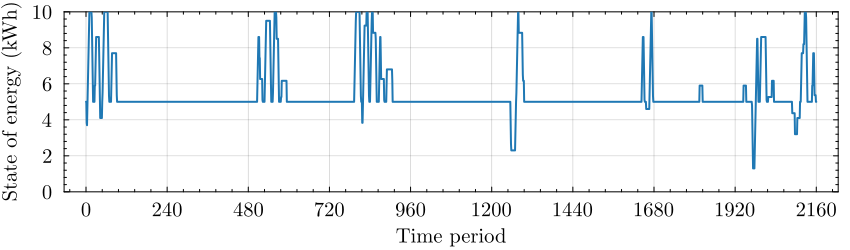

In [29]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_fix[1:T_tot+1], linewidth=2, color=color_eff)

In [30]:
savefig(plt_soe,"soe_eff_fix.pdf");

### Rolling horizon 2 days

In [31]:
e_RH2 = [E_init_all]
profit_RH2 =[0.0]
use_RH2 =[0.0]
t = 1
T_RH = 48
E_init = E_init_all

while t <= T_tot
    T = min(T_RH, T_tot-t+1)
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T , C[t:t+T-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH2, e_val[1:H])
    append!(profit_RH2, profit[1:H])
    append!(use_RH2, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH2), digits=3))
println("Total storage use: ",round(sum(use_RH2), digits=3))

Total profit: 3.862
Total storage use: 241.929


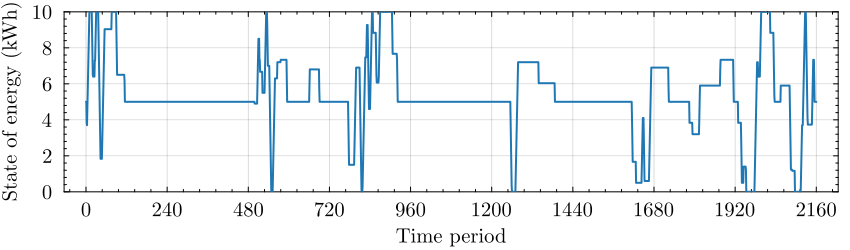

In [32]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH2[1:T_tot+1], linewidth=2, color=color_eff)

In [33]:
savefig(plt_soe,"soe_eff_RH.pdf");

### Minimum forecast horizon

In [34]:
# Min forecast horizon and solving

E_init = E_init_all
e_RH_min = [E_init]
profit_RH_min =[0.0]
use_RH_min =[0.0]
t = 1
T_min_fcst = []
T_LB_1 = []
T_LB_2 = []
T_LB_3 = []
T_LB = []

while t <= T_tot
    println("t=",t)

    # Lower bound on forecast horizon
    expr = 10
    expr_1 = 10
    expr_2 = 10
    expr_3 = 10
    T_min_1 = H+1
    while expr_1 > 0
        expr_1 = E_max - E_min - sum(ρ^i for i=0:T_min_1-H-1) * Δt * (η_ch * P_ch + (1/η_dis) * P_dis)
        T_min_1 += 1
    end
    append!(T_LB_1,(T_min_1-1).*(ones(H)))
    T_min_2 = H+1
    while expr_2 > 0
        expr_2 = ρ^T_min_2 * E_init - E_min + sum(ρ^i for i=T_min_2-H:T_min_2-1) * Δt * (η_ch * P_ch) - sum(ρ^i for i=0:T_min_2-H-1) * Δt * ((1/η_dis) * P_dis)
        T_min_2 += 1
    end
    append!(T_LB_2,(T_min_2-1).*(ones(H)))
    T_min_3 = H+1
    while expr_3 > 0
        expr_3 = E_max - ρ^T_min_3 * E_init - sum(ρ^i for i=0:T_min_3-H-1) * Δt * (η_ch * P_ch) + sum(ρ^i for i=T_min_3-H:T_min_3-1) * Δt * ((1/η_dis) * P_dis)
        T_min_3 += 1
    end
    append!(T_LB_3,(T_min_3-1).*(ones(H)))
    T_min = (min(T_min_1,T_min_2,T_min_3)-1)
    append!(T_LB,T_min.*(ones(H)))
    println("T_min = ", T_min)
    if T_min > T_max 
        println("The maximum planning horizon is too short")
    end

    # Min forecast horizon
    T_max_end = min(T_max, T_tot-t+1)
    T_fcst, e_val, profit, use = min_fcst_hor(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH_min, e_val[1:H])
    append!(profit_RH_min, profit[1:H])
    append!(use_RH_min, use[1:H])
    append!(T_min_fcst, T_fcst.*(ones(H)))
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH_min), digits=3))
println("Total storage use: ",round(sum(use_RH_min), digits=3))

t=1
T_min = 29
t=25
T_min = 29
t=49
T_min = 29
t=73
T_min = 29
t=97
T_min = 29
t=121
T_min = 29
t=145
T_min = 29
t=169
T_min = 29
t=193
T_min = 29
t=217
T_min = 29
t=241
T_min = 29
t=265
T_min = 29
t=289
T_min = 29
t=313
T_min = 29
t=337
T_min = 29
t=361
T_min = 29
t=385
T_min = 29
t=409
T_min = 29
t=433
T_min = 29
t=457
T_min = 29
t=481
T_min = 29
t=505
T_min = 29
t=529
T_min = 29
t=553
T_min = 29
t=577
T_min = 29
t=601
T_min = 29
t=625
T_min = 29
t=649
T_min = 29
t=673
T_min = 29
t=697
T_min = 29
t=721
T_min = 29
t=745
T_min = 29
t=769
T_min = 29
t=793
T_min = 29
t=817
T_min = 29
t=841
T_min = 29
t=865
T_min = 29
t=889
T_min = 29
t=913
T_min = 29
t=937
T_min = 29
t=961
T_min = 29
t=985
T_min = 29
t=1009
T_min = 29
t=1033
T_min = 29
t=1057
T_min = 29
t=1081
T_min = 29
t=1105
T_min = 29
t=1129
T_min = 29
t=1153
T_min = 29
t=1177
T_min = 29
t=1201
T_min = 29
t=1225
T_min = 29
t=1249
T_min = 29
t=1273
T_min = 29
t=1297
T_min = 29
t=1321
T_min = 29
t=1345
T_min = 29
t=1369
T_min = 29
t=13

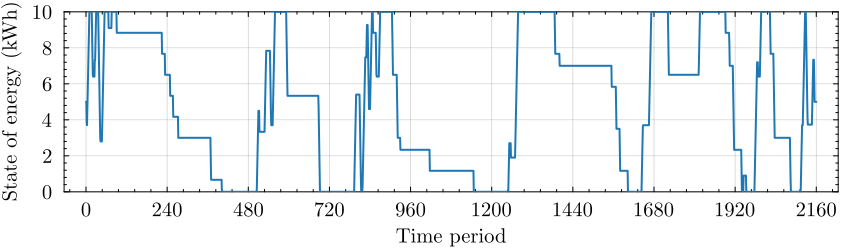

In [35]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH_min[1:T_tot+1], linewidth=2, color=color_eff)

In [36]:
savefig(plt_soe,"soe_eff_fcst.pdf");

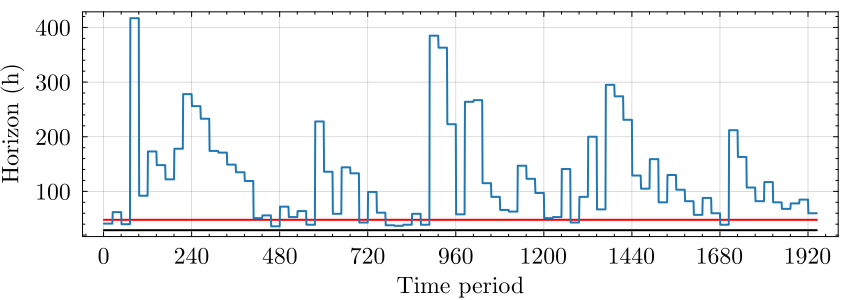

In [37]:
# Plot min horizon
plt_fcst = plot(legend=false, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, xticks=0:10*H:T_tot, size=(850,300), ylabel="Horizon (h)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_fcst, [1:T_plt_fcst], (T_RH).*ones(T_plt_fcst), linewidth=2, color=:red)
plot!(plt_fcst, [1:T_plt_fcst], T_LB[1:T_plt_fcst], linewidth=2, color=:black)
plot!(plt_fcst, [1:T_plt_fcst], T_min_fcst[1:T_plt_fcst], linewidth=2, color=color_eff)

In [38]:
T_min_fcst_2 = T_min_fcst[1:T_plt_fcst];

In [39]:
savefig(plt_fcst,"min_fcst_eff.pdf");

## Slow storage

In [40]:
# Storage data
P_ch = 1.0 # Max charge (kW)
P_dis = 1.0 # Max discharge (kW)
η_ch = 0.9 # Charging efficiency
η_dis = 0.9 # Discharging efficiency
E_min = 0.0 # Min capacity (kWh)
E_max = 50.0 # Max capacity (kWh)
E_half = E_max / 2
E_init_all = E_half # Initial state of energy (kWh)
ρ = 1.0 # Proportion of stored energy that is still available in the next period (i.e. does not leak)

color_slow="#b2df8a"
;

### Fixed final level

In [41]:
E_init = E_init_all
e_fix = [E_init]
profit_fix =[0.0]
use_fix =[0.0]
t = 1

while t <= T_tot
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, H , C[t:t+H-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_fix, e_val[1:H])
    append!(profit_fix, profit[1:H])
    append!(use_fix, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_fix), digits=3))
println("Total storage use: ",round(sum(use_fix), digits=3))

Total profit: 13.258
Total storage use: 1185.617


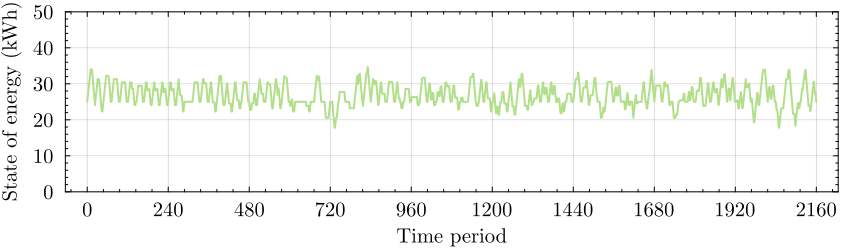

In [42]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_fix[1:T_tot+1], linewidth=2, color=color_slow)

In [43]:
savefig(plt_soe,"soe_slow_fix.pdf");

### Rolling horizon 2 days

In [44]:
e_RH2 = [E_init_all]
profit_RH2 =[0.0]
use_RH2 =[0.0]
t = 1
T_RH = 48
E_init = E_init_all

while t <= T_tot
    T = min(T_RH, T_tot-t+1)
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T , C[t:t+T-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH2, e_val[1:H])
    append!(profit_RH2, profit[1:H])
    append!(use_RH2, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH2), digits=3))
println("Total storage use: ",round(sum(use_RH2), digits=3))

Total profit: 18.243
Total storage use: 1291.982


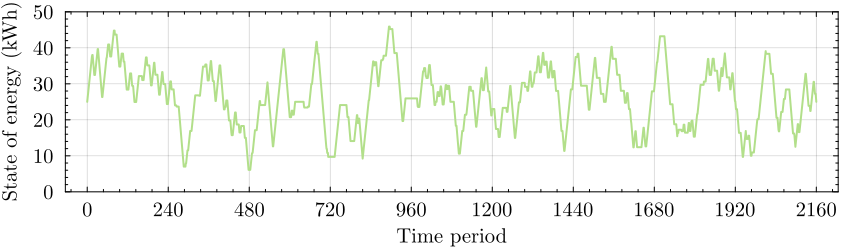

In [45]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH2[1:T_tot+1], linewidth=2, color=color_slow)

In [46]:
savefig(plt_soe,"soe_slow_RH.pdf");

### Minimum forecast horizon

In [47]:
# Min forecast horizon and solving

E_init = E_init_all
e_RH_min = [E_init]
profit_RH_min =[0.0]
use_RH_min =[0.0]
t = 1
T_min_fcst = []
T_LB_1 = []
T_LB_2 = []
T_LB_3 = []
T_LB = []

while t <= T_tot
    println("t=",t)

    # Lower bound on forecast horizon
    expr = 10
    expr_1 = 10
    expr_2 = 10
    expr_3 = 10
    T_min_1 = H+1
    while expr_1 > 0
        expr_1 = E_max - E_min - sum(ρ^i for i=0:T_min_1-H-1) * Δt * (η_ch * P_ch + (1/η_dis) * P_dis)
        T_min_1 += 1
    end
    append!(T_LB_1,(T_min_1-1).*(ones(H)))
    T_min_2 = H+1
    while expr_2 > 0
        expr_2 = ρ^T_min_2 * E_init - E_min + sum(ρ^i for i=T_min_2-H:T_min_2-1) * Δt * (η_ch * P_ch) - sum(ρ^i for i=0:T_min_2-H-1) * Δt * ((1/η_dis) * P_dis)
        T_min_2 += 1
    end
    append!(T_LB_2,(T_min_2-1).*(ones(H)))
    T_min_3 = H+1
    while expr_3 > 0
        expr_3 = E_max - ρ^T_min_3 * E_init - sum(ρ^i for i=0:T_min_3-H-1) * Δt * (η_ch * P_ch) + sum(ρ^i for i=T_min_3-H:T_min_3-1) * Δt * ((1/η_dis) * P_dis)
        T_min_3 += 1
    end
    append!(T_LB_3,(T_min_3-1).*(ones(H)))
    T_min = (min(T_min_1,T_min_2,T_min_3)-1)
    append!(T_LB,T_min.*(ones(H)))
    println("T_min = ", T_min)
    if T_min > T_max 
        println("The maximum planning horizon is too short")
    end

    # Min forecast horizon
    T_max_end = min(T_max, T_tot-t+1)
    T_fcst, e_val, profit, use = min_fcst_hor(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH_min, e_val[1:H])
    append!(profit_RH_min, profit[1:H])
    append!(use_RH_min, use[1:H])
    append!(T_min_fcst, T_fcst.*(ones(H)))
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH_min), digits=3))
println("Total storage use: ",round(sum(use_RH_min), digits=3))

t=1
T_min = 49
t=25
T_min = 49
t=49
T_min = 49
t=73
T_min = 49
t=97
T_min = 49
t=121
T_min = 49
t=145
T_min = 49
t=169
T_min = 49
t=193
T_min = 49
t=217
T_min = 49
t=241
T_min = 49
t=265
T_min = 49
t=289
T_min = 44
t=313
T_min = 49
t=337
T_min = 49
t=361
T_min = 49
t=385
T_min = 49
t=409
T_min = 49
t=433
T_min = 44
t=457
T_min = 44
t=481
T_min = 44
t=505
T_min = 49
t=529
T_min = 49
t=553
T_min = 49
t=577
T_min = 49
t=601
T_min = 49
t=625
T_min = 49
t=649
T_min = 49
t=673
T_min = 49
t=697
T_min = 49
t=721
T_min = 44
t=745
T_min = 49
t=769
T_min = 49
t=793
T_min = 49
t=817
T_min = 49
t=841
T_min = 49
t=865
T_min = 49
t=889
T_min = 49
t=913
T_min = 49
t=937
T_min = 49
t=961
T_min = 49
t=985
T_min = 49
t=1009
T_min = 49
t=1033
T_min = 49
t=1057
T_min = 49
t=1081
T_min = 49
t=1105
T_min = 44
t=1129
T_min = 49
t=1153
T_min = 49
t=1177
T_min = 49
t=1201
T_min = 49
t=1225
T_min = 49
t=1249
T_min = 49
t=1273
T_min = 49
t=1297
T_min = 49
t=1321
T_min = 49
t=1345
T_min = 49
t=1369
T_min = 49
t=13

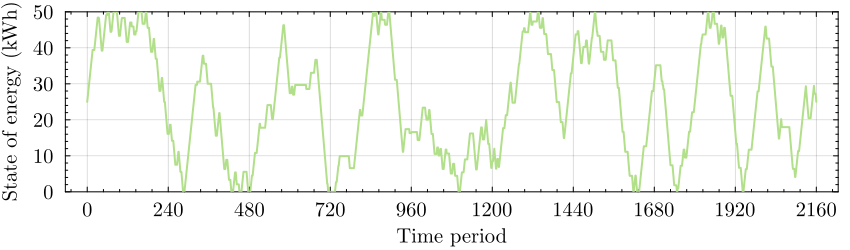

In [48]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH_min[1:T_tot+1], linewidth=2, color=color_slow)

In [49]:
savefig(plt_soe,"soe_slow_fcst.pdf");

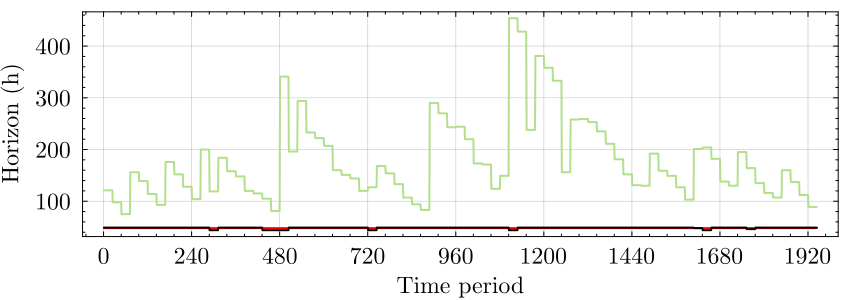

In [50]:
# Plot min horizon
plt_fcst = plot(legend=false, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, xticks=0:10*H:T_tot, size=(850,300), ylabel="Horizon (h)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_fcst, [1:T_plt_fcst], (T_RH).*ones(T_plt_fcst), linewidth=2, color=:red)
plot!(plt_fcst, [1:T_plt_fcst], T_LB[1:T_plt_fcst], linewidth=2, color=:black)
plot!(plt_fcst, [1:T_plt_fcst], T_min_fcst[1:T_plt_fcst], linewidth=2, color=color_slow)

In [51]:
T_min_fcst_3 = T_min_fcst[1:T_plt_fcst];

In [52]:
savefig(plt_fcst,"min_fcst_slow.pdf");

## Slow storage + leakage

In [53]:
# Storage data
P_ch = 1.0 # Max charge (kW)
P_dis = 1.0 # Max discharge (kW)
η_ch = 0.9 # Charging efficiency
η_dis = 0.9 # Discharging efficiency
E_min = 0.0 # Min capacity (kWh)
E_max = 50.0 # Max capacity (kWh)
E_half = E_max / 2
E_init_all = E_half # Initial state of energy (kWh)
ρ = 0.99 # Proportion of stored energy that is still available in the next period (i.e. does not leak)

color_leak="#33a02c"
;

### Fixed final level

In [54]:
E_init = E_init_all
e_fix = [E_init]
profit_fix =[0.0]
use_fix =[0.0]
t = 1

while t <= T_tot
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, H , C[t:t+H-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_fix, e_val[1:H])
    append!(profit_fix, profit[1:H])
    append!(use_fix, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_fix), digits=3))
println("Total storage use: ",round(sum(use_fix), digits=3))

Total profit: -25.167
Total storage use: 1229.069


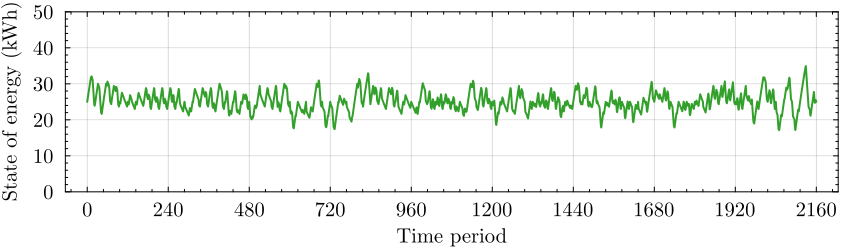

In [55]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_fix[1:T_tot+1], linewidth=2, color=color_leak)

In [56]:
savefig(plt_soe,"soe_slow_leak_fix.pdf");

### Rolling horizon 2 days

In [57]:
e_RH2 = [E_init_all]
profit_RH2 =[0.0]
use_RH2 =[0.0]
t = 1
T_RH = 48
E_init = E_init_all

while t <= T_tot
    T = min(T_RH, T_tot-t+1)
    e_val, profit, use = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T , C[t:t+T-1], ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH2, e_val[1:H])
    append!(profit_RH2, profit[1:H])
    append!(use_RH2, use[1:H])
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH2), digits=3))
println("Total storage use: ",round(sum(use_RH2), digits=3))

Total profit: -3.49
Total storage use: 1267.855


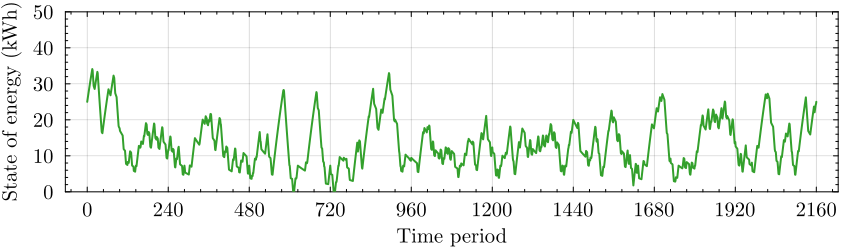

In [58]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH2[1:T_tot+1], linewidth=2, color=color_leak)

In [59]:
savefig(plt_soe,"soe_slow_leak_RH.pdf");

### Minimum forecast horizon

In [60]:
# Min forecast horizon and solving

E_init = E_init_all
e_RH_min = [E_init]
profit_RH_min =[0.0]
use_RH_min =[0.0]
t = 1
T_min_fcst = []
T_LB_1 = []
T_LB_2 = []
T_LB_3 = []
T_LB = []

while t <= T_tot
    println("t=",t)

    # Lower bound on forecast horizon
    expr = 10
    expr_1 = 10
    expr_2 = 10
    expr_3 = 10
    T_min_1 = H+1
    while expr_1 > 0
        expr_1 = E_max - E_min - sum(ρ^i for i=0:T_min_1-H-1) * Δt * (η_ch * P_ch + (1/η_dis) * P_dis)
        T_min_1 += 1
    end
    append!(T_LB_1,(T_min_1-1).*(ones(H)))
    T_min_2 = H+1
    while expr_2 > 0
        expr_2 = ρ^T_min_2 * E_init - E_min + sum(ρ^i for i=T_min_2-H:T_min_2-1) * Δt * (η_ch * P_ch) - sum(ρ^i for i=0:T_min_2-H-1) * Δt * ((1/η_dis) * P_dis)
        T_min_2 += 1
    end
    append!(T_LB_2,(T_min_2-1).*(ones(H)))
    T_min_3 = H+1
    while expr_3 > 0
        expr_3 = E_max - ρ^T_min_3 * E_init - sum(ρ^i for i=0:T_min_3-H-1) * Δt * (η_ch * P_ch) + sum(ρ^i for i=T_min_3-H:T_min_3-1) * Δt * ((1/η_dis) * P_dis)
        T_min_3 += 1
    end
    append!(T_LB_3,(T_min_3-1).*(ones(H)))
    T_min = (min(T_min_1,T_min_2,T_min_3)-1)
    append!(T_LB,T_min.*(ones(H)))
    println("T_min = ", T_min)
    if T_min > T_max 
        println("The maximum planning horizon is too short")
    end

    # Min forecast horizon
    T_max_end = min(T_max, T_tot-t+1)
    T_fcst, e_val, profit, use = min_fcst_hor(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_init_all)
    append!(e_RH_min, e_val[1:H])
    append!(profit_RH_min, profit[1:H])
    append!(use_RH_min, use[1:H])
    append!(T_min_fcst, T_fcst.*(ones(H)))
    E_init = e_val[H]
    t += H
end

println("Total profit: ",round(sum(profit_RH_min), digits=3))
println("Total storage use: ",round(sum(use_RH_min), digits=3))

t=1
T_min = 53
t=25
T_min = 50
t=49
T_min = 45
t=73
T_min = 46
t=97
T_min = 40
t=121
T_min = 40
t=145
T_min = 40
t=169
T_min = 40
t=193
T_min = 40
t=217
T_min = 40
t=241
T_min = 40
t=265
T_min = 40
t=289
T_min = 40
t=313
T_min = 40
t=337
T_min = 41
t=361
T_min = 40
t=385
T_min = 41
t=409
T_min = 40
t=433
T_min = 40
t=457
T_min = 40
t=481
T_min = 40
t=505
T_min = 41
t=529
T_min = 40
t=553
T_min = 41
t=577
T_min = 48
t=601
T_min = 40
t=625
T_min = 40
t=649
T_min = 40
t=673
T_min = 44
t=697
T_min = 40
t=721
T_min = 40
t=745
T_min = 42
t=769
T_min = 40
t=793
T_min = 40
t=817
T_min = 40
t=841
T_min = 49
t=865
T_min = 42
t=889
T_min = 45
t=913
T_min = 40
t=937
T_min = 40
t=961
T_min = 40
t=985
T_min = 40
t=1009
T_min = 40
t=1033
T_min = 40
t=1057
T_min = 40
t=1081
T_min = 40
t=1105
T_min = 40
t=1129
T_min = 40
t=1153
T_min = 40
t=1177
T_min = 40
t=1201
T_min = 40
t=1225
T_min = 40
t=1249
T_min = 41
t=1273
T_min = 42
t=1297
T_min = 43
t=1321
T_min = 40
t=1345
T_min = 40
t=1369
T_min = 40
t=13

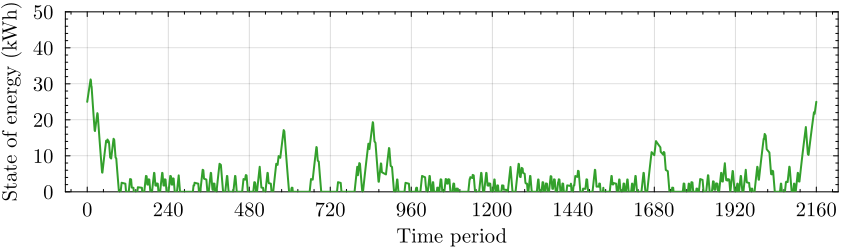

In [61]:
# Plot soe
plt_soe = plot(legend=false, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, ylims=[E_min,E_max], xticks=0:10*H:T_tot, size=(850,250), ylabel="State of energy (kWh)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_soe, [0:T_tot], e_RH_min[1:T_tot+1], linewidth=2, color=color_leak)

In [62]:
savefig(plt_soe,"soe_slow_leak_fcst.pdf");

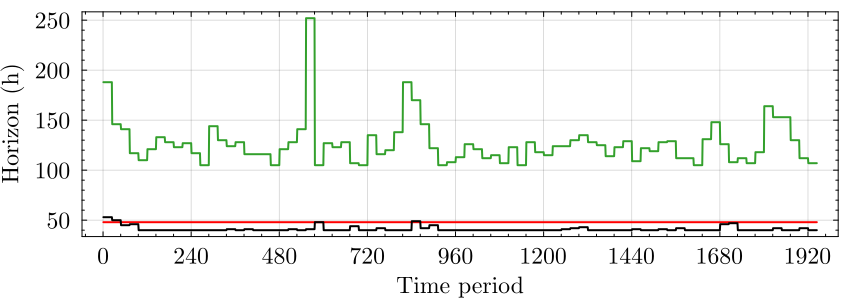

In [63]:
# Plot min horizon
plt_fcst = plot(legend=false, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, xticks=0:10*H:T_tot, size=(850,300), ylabel="Horizon (h)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=4Plots.mm)
plot!(plt_fcst, [1:T_plt_fcst], (T_RH).*ones(T_plt_fcst), linewidth=2, color=:red)
plot!(plt_fcst, [1:T_plt_fcst], T_LB[1:T_plt_fcst], linewidth=2, color=:black)
plot!(plt_fcst, [1:T_plt_fcst], T_min_fcst[1:T_plt_fcst], linewidth=2, color=color_leak)

In [64]:
T_min_fcst_4 = T_min_fcst[1:T_plt_fcst];

In [65]:
savefig(plt_fcst,"min_fcst_slow_leak.pdf");

## Plot min fcst hor all

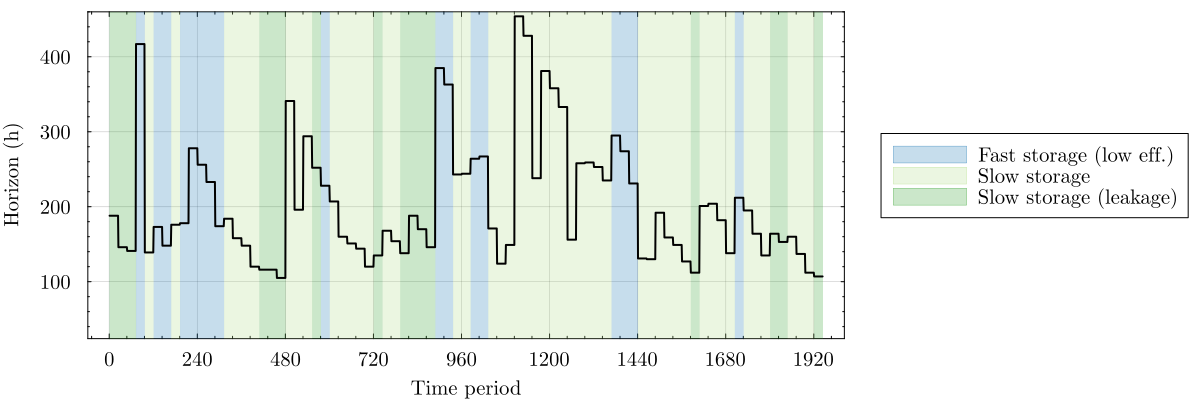

In [66]:
plt_fcst = plot(legend=:outerright, legendfontsize=13, tickfontsize=13, minorgrid=false, gridalpha=0.1, titlefontsize=13, guidefontsize=13, xticks=0:10*H:T_tot, size=(1200,400), ylabel="Horizon (h)", xlabel="Time period", bottom_margin=7Plots.mm, left_margin=6Plots.mm, ylims=[24,460])  # , title="Minimum forecast horizon"

T_enveloppe = []
count_fast = 0
count_eff = 0
count_slow = 0
count_leak = 0
start_vspace = 1
end_vspace = 0.9999
current_col = color_leak

for t in 1:T_plt_fcst
    T_upp = max(T_min_fcst_1[t],T_min_fcst_2[t],T_min_fcst_3[t],T_min_fcst_4[t])
    append!(T_enveloppe,T_upp)
    if T_upp == T_min_fcst_1[t]
        col_fcst = color_fast
        count_fast += 1
    elseif T_upp == T_min_fcst_2[t]
        col_fcst = color_eff
        count_eff += 1
    elseif T_upp == T_min_fcst_3[t]
        col_fcst = color_slow
        count_slow += 1
    elseif T_upp == T_min_fcst_4[t]
        col_fcst = color_leak
        count_leak += 1
    end
    if col_fcst == current_col
        end_vspace += 1
    else
        vspan!(plt_fcst, [start_vspace,end_vspace], linecolor=current_col,fillcolor=current_col,alpha=0.25,label=false)
        start_vspace = t
        end_vspace += 1
        current_col = col_fcst
    end
end

vspan!(plt_fcst, [start_vspace,end_vspace], linecolor=current_col,fillcolor=current_col,alpha=0.25,label=false)

vspan!(plt_fcst, [0,0], linecolor=color_eff, color=color_eff,alpha=0.25,label="Fast storage (low eff.)")
vspan!(plt_fcst, [0,0], linecolor=color_slow, color=color_slow,alpha=0.25,label="Slow storage")
vspan!(plt_fcst, [0,0], linecolor=color_leak, color=color_leak,alpha=0.25, label="Slow storage (leakage)")

plot!(plt_fcst, [1:T_plt_fcst], T_enveloppe, linewidth=2, color=:black,label=false)

In [67]:
savefig(plt_fcst,"min_fcst_all.pdf");

## Suboptimality

In [68]:
# Storage data
P_ch = 1.0 # Max charge (kW)
P_dis = 1.0 # Max discharge (kW)
η_ch = 0.9 # Charging efficiency
η_dis = 0.9 # Discharging efficiency
E_min = 0.0 # Min capacity (kWh)
E_max = 50.0 # Max capacity (kWh)
E_half = E_max / 2
E_init_all = E_half # Initial state of energy (kWh)
ρ = 0.99 # Proportion of stored energy that is still available in the next period (i.e. does not leak)

# Prices 
C_min_all = -500
C_max_all = 4000

C_min_hist = 440.1
C_max_hist = 871

C_min = -0.001*C_min_all
C_max = 0.001*C_max_all

T_test = 90

;

In [69]:
# Subopt upper bound

E_init = E_init_all
t = 1
T_min = 40
T_max_end = min(T_max, T_tot-t+1)

gap_vec, subopt_bound_vec = subopt_UB(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init, E_init_all, E_half, C_min, C_max)
T_fcst = T_min + length(gap_vec)
;

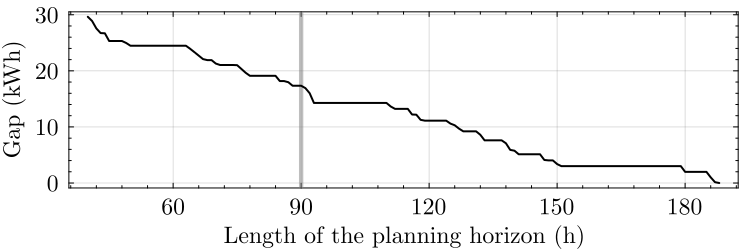

In [70]:
# Plot gap
plt_gap = plot(legend=false, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, size=(750,250), xlabel="Length of the planning horizon (h)", ylabel="Gap (kWh)", bottom_margin=7Plots.mm, left_margin=4Plots.mm) # , title="State of energy"
vspan!(plt_gap, [T_test-0.5,T_test+0.5], linecolor=:gray, color=:gray,alpha=0.5)
plot!(plt_gap, [T_min:T_fcst-1], gap_vec, linewidth=2, color=:black)

In [71]:
savefig(plt_gap,"gap.pdf");

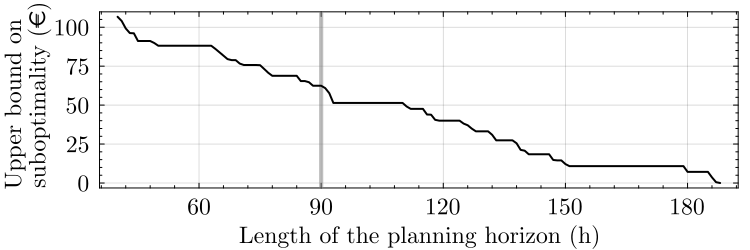

In [72]:
# Plot bound
plt_UB = plot(legend=false, tickfontsize=15, minorgrid=false, gridalpha=0.1, titlefontsize=15, guidefontsize=15, size=(750,250), xlabel="Length of the planning horizon (h)", ylabel="Upper bound on \n suboptimality (€)", bottom_margin=7Plots.mm, left_margin=7Plots.mm) # , title="State of energy"
vspan!(plt_UB, [T_test-0.5,T_test+0.5], linecolor=:gray, color=:gray,alpha=0.5)
plot!(plt_UB, [T_min:T_fcst-1], subopt_bound_vec, linewidth=2, color=:black)

In [73]:
savefig(plt_UB,"bound.pdf");

In [74]:
# Actual suboptimality

profit_inf = 0
profit_sub = 0
t = 1
E_init_inf = E_init_all
E_init_sub = E_init_all
T = 90

# Get final levels for max reachable level and min reachable level
E_final_up = min(E_max, E_init * ρ^T + Δt * η_ch * P_ch * sum(ρ^(i-1) for i in 1:T))
E_final_low = max(E_min, E_init * ρ^T - Δt *(1/η_dis) * P_dis * sum(ρ^(i-1) for i in 1:T))
e_val_up, profit_up, use_up = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init_sub, E_final_up)
e_val_low, profit_low, use_low = schedule_opt_bin(E_min, E_max, P_ch, P_dis, T, C[t:T+t-1], ρ, η_ch, η_dis, E_init_sub, E_final_low)

# Use as bounds
e_end, profit = schedule_bin_bounds(E_min, E_max, P_ch, P_dis, H, C[t:H+t-1], ρ, η_ch, η_dis, E_init_sub, e_val_low[H], e_val_up[H])
E_init_sub = e_end
profit_sub += profit
println("e_val_low[H] = ",e_val_low[H])
println("e_val_up[H] = ",e_val_up[H])
println("e_end = ",e_end)
println("profit_sub = ",profit_sub)

# Forecast horizon
# Min forecast horizon
T_max_end = min(T_max, T_tot-t+1)
T_fcst, e_val, profit, use = min_fcst_hor(t, H, T, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init_inf, E_init_all)
profit_inf += sum(profit[1:H])
E_init_inf = e_val[H]
println("e_val[H] = ",e_val[H])
println("profit_inf = ",profit_inf)

t += H

# Repeat until they merge 
gap_inf_sub = abs(E_init_inf - E_init_sub)
println("gap_inf_sub = ", gap_inf_sub)

while gap_inf_sub != 0 && t <= T_tot # 
    println("t = ", t)
    T_min = 39
    T_max_end = min(T_max, T_tot-t+1)

    # Subopt
    T_fcst, e_val, profit, use = min_fcst_hor(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init_sub, E_init_all)
    profit_sub += sum(profit[1:H])
    E_init_sub = e_val[H]
    println("profit_sub = ", profit_sub)
    println("E_init_sub = ", E_init_sub)

    # Infinite
    T_fcst, e_val, profit, use = min_fcst_hor(t, H, T_min, T_max_end, E_min, E_max, P_ch, P_dis, C, ρ, η_ch, η_dis, E_init_inf, E_init_all)
    #println("e_val = ",e_val)
    profit_inf += sum(profit[1:H])
    E_init_inf = e_val[H]
    println("profit_inf = ", profit_inf)
    println("E_init_inf = ", E_init_inf)

    gap_inf_sub = abs(E_init_inf - E_init_sub)
    println("gap_inf_sub = ", gap_inf_sub)
    t += H
end

println("Suboptimality gap: ",round((profit_inf-profit_sub), digits=3))

e_val_low[H] = 14.545356526625286
e_val_up[H] = 31.892384066168436
e_end = 14.545356526625277
profit_sub = 0.5675800000000005
e_val[H] = 17.615200168022707
profit_inf = 0.43557000000000035
gap_inf_sub = 3.06984364139743
t = 25
profit_sub = 1.2817000000000005
E_init_sub = 5.423729351511592
profit_inf = 1.1496900000000005
E_init_inf = 7.835638396253591
gap_inf_sub = 2.411909044741999
t = 49
profit_sub = 1.3702500000000004
E_init_sub = 8.709145137680784
profit_inf = 1.277378493222089
E_init_inf = 10.053335413841546
gap_inf_sub = 1.344190276160763
t = 73
profit_sub = 2.2786645983428864
E_init_sub = 0.0
profit_inf = 2.281658493222089
E_init_inf = 0.0
gap_inf_sub = 0.0
Suboptimality gap: 0.003


In [75]:
# Upper bound on suboptimality for planning horizon T_test
subopt_max = subopt_bound_vec[T_test-T_min+1]
subopt_gap_max = (subopt_max / profit_inf)*100
println("Upper bound on suboptimality for a planning horizon of ",T_test," hours: ",round(subopt_max,digits=2)," €.")
println("Corresponding upper bound on suboptimality gap: ",round(subopt_gap_max,digits=0)," %.")

Upper bound on suboptimality for a planning horizon of 90 hours: 60.9 €.
Corresponding upper bound on suboptimality gap: 2669.0 %.
